In [1]:
# importações
from utils import *
from models import *
from config import *


# 1. Aplicabilidade do Modelo 2 no Mercado Real

In [2]:
# Lista de ações
stock_list = ['PETR4', 'VALE3', 'BBDC4','ITUB4']

# Carrega os dados de todas as ações e calcula os indicadores e salva em um dicionario
all_stock_data = load_stocks_data(stock_list)

Carregando dados para: PETR4
Carregando dados para: VALE3
Carregando dados para: BBDC4
Carregando dados para: ITUB4


In [3]:
# Processando o Modelo 2 para Salvar os Artefatos (modelo e scalers)

name_model = model_2

# Usando a Combinação 4: ("Stock Data + IT (IFR + MMS + MME)", stock_data + ifr + mms + mme),
result = process_stocks_and_save_metrics(all_stock_data, 4, name_model, save_artifacts=True) # Salva os artefatos



model_2: Processando PETR4 | Combinação 4...
Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0477 - mae: 0.1559 - mape: 12494.3340 - mse: 0.0477 - val_loss: 0.0011 - val_mae: 0.0274 - val_mape: 6.2344 - val_mse: 0.0011
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 5.0835e-04 - mae: 0.0169 - mape: 7107.8828 - mse: 5.0835e-04 - val_loss: 4.0056e-04 - val_mae: 0.0138 - val_mape: 3.3526 - val_mse: 4.0056e-04
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 2.7505e-04 - mae: 0.0121 - mape: 15225.4199 - mse: 2.7505e-04 - val_loss: 3.5683e-04 - val_mae: 0.0125 - val_mape: 3.0559 - val_mse: 3.5683e-04
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 2.4144e-04 - mae: 0.0112 - mape: 483.9948 - mse: 2.4144e-04 - val_loss: 3.8235e-04 - val_mae: 0.0128 - val_mape: 3.1414 - val_mse: 3.8235e-04
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 2.6935e-04 - mae: 0.0122 - mape: 3474.6865 - mse: 2.6935e-04 - val_loss: 3.7083e-04 - val_mae: 0.0125 -

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
model_2: Processando VALE3 | Combinação 4...
Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0798 - mae: 0.2043 - mape: 62142.6328 - mse: 0.0798 - val_loss: 0.0163 - val_mae: 0.0981 - val_mape: 8.2602 - val_mse: 0.0163
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 6.8037e-04 - mae: 0.0197 - mape: 13922.0576 - mse: 6.8037e-04 - val_loss: 0.0032 - val_mae: 0.0430 - val_mape: 3.9443 - val_mse: 0.0032
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 4.2572e-04 - mae: 0.0159 - mape: 41348.7344 - mse: 4.2572e-04 - val_loss: 0.0015 - val_mae: 0.0291 - val_mape: 2.8017 - val_mse: 0.0015
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 4.6836e-04 - mae: 0.0152 - mape: 5488.1689 - mse: 4.6836e-04 - val_loss: 0.0020 - val_mae: 0.0326 - val_mape: 2.9830 - val_mse: 0.0020
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 3.4733e-04 - mae: 0.0141 - mape: 7263.1504 - mse: 3.4733e-04 - val_loss: 0.0039 - val

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
model_2: Processando BBDC4 | Combinação 4...
Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0590 - mae: 0.1646 - mape: 5495.0508 - mse: 0.0590 - val_loss: 0.0013 - val_mae: 0.0265 - val_mape: 5.1127 - val_mse: 0.0013
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 7.6749e-04 - mae: 0.0204 - mape: 3855.4758 - mse: 7.6749e-04 - val_loss: 7.2998e-04 - val_mae: 0.0191 - val_mape: 3.7572 - val_mse: 7.2998e-04
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 5.2581e-04 - mae: 0.0154 - mape: 3427.8923 - mse: 5.2581e-04 - val_loss: 6.3439e-04 - val_mae: 0.0179 - val_mape: 3.5351 - val_mse: 6.3439e-04
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 5.2904e-04 - mae: 0.0156 - mape: 741.0027 - mse: 5.2904e-04 - val_loss: 7.8301e-04 - val_mae: 0.0212 - val_mape: 4.0637 - val_mse: 7.8301e-04
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 4.2967e-04 - mae: 0.0147 - mape: 103.4864 - mse: 4.2967e-04 - val

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
model_2: Processando ITUB4 | Combinação 4...
Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0657 - mae: 0.1784 - mape: 47790.4688 - mse: 0.0657 - val_loss: 0.0020 - val_mae: 0.0353 - val_mape: 5.8010 - val_mse: 0.0020
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 5.6756e-04 - mae: 0.0183 - mape: 8641.0586 - mse: 5.6756e-04 - val_loss: 6.9268e-04 - val_mae: 0.0192 - val_mape: 3.2077 - val_mse: 6.9268e-04
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 3.1617e-04 - mae: 0.0132 - mape: 45058.8711 - mse: 3.1617e-04 - val_loss: 5.2973e-04 - val_mae: 0.0163 - val_mape: 2.7555 - val_mse: 5.2973e-04
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 2.6704e-04 - mae: 0.0121 - mape: 47019.1641 - mse: 2.6704e-04 - val_loss: 5.0331e-04 - val_mae: 0.0159 - val_mape: 2.6916 - val_mse: 5.0331e-04
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 2.6906e-04 - mae: 0.0121 - mape: 18248.7051 - mse: 2.6906e-04

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


In [3]:
# Lista de ações
stock_list = ['PETR4']

# Carrega os dados de todas as ações e calcula os indicadores e salva em um dicionario
all_stock_data = load_stocks_data(stock_list)

Carregando dados para: PETR4


In [4]:
for stock in stock_list:
    print(stock)

PETR4


In [6]:
for stock in stock_list:
    df = make_predictions(stock, all_stock_data[stock])

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [11]:
# Função para gerar sinais de compra e venda
signals_df = generate_signals(df)

In [20]:
signals_df.tail(10)

,open,close,high,low,volume,ifr_14,mms_30,mms_5,mme_5,mme_30,close_next_day,close_predicted,signal
date,,,,,,,,,,,,,
2022-09-02,0.625052,0.604844,0.613236,0.609241,0.117022,57.899626,0.606037,0.606127,0.605421,0.592981,0.603188,0.610593,1
2022-09-05,0.612856,0.603188,0.603926,0.606941,0.109217,56.303329,0.607859,0.601408,0.604676,0.593640,0.577520,0.606012,1
2022-09-06,0.580198,0.577520,0.573163,0.572653,0.159973,47.010869,0.608611,0.600041,0.595624,0.592600,0.571310,0.579541,1
2022-09-08,0.581025,0.571310,0.577009,0.570353,0.090364,42.415733,0.608922,0.594121,0.587520,0.591226,0.571103,0.575519,1
2022-09-09,0.584746,0.571103,0.574782,0.576626,0.071353,50.333341,0.608577,0.585593,0.582048,0.589928,0.564686,0.576727,1
2022-09-12,0.577718,0.564686,0.575997,0.571608,0.102117,44.611816,0.606734,0.577562,0.576260,0.588300,0.547506,0.571255,1
2022-09-13,0.552708,0.547506,0.549889,0.551955,0.126372,33.451960,0.604644,0.566425,0.566676,0.585668,0.557235,0.550996,1
2022-09-14,0.548780,0.557235,0.549686,0.554255,0.070162,35.517248,0.602774,0.562368,0.563529,0.583833,0.555993,0.553562,-1
2022-09-15,0.552294,0.555993,0.545639,0.557809,0.065174,36.785718,0.600849,0.559305,0.561017,0.582037,0.550197,0.553255,-1


In [ ]:
def run_backtest(signals_df, initial_money=10000):
    """
    Executa um backtest com base nos sinais de compra e venda, mantendo posições enquanto os sinais forem os mesmos.

    Parâmetros:
        signals_df (pd.DataFrame): DataFrame contendo as colunas 'signal' e 'close'.
        initial_money (float): Quantia inicial em dinheiro para o backtest. Padrão: 10.000.

    Retorna:
        float: Valor final do portfólio após o backtest.
    """
    # Verificando se as colunas necessárias estão no DataFrame
    required_columns = {'signal', 'close'}
    if not required_columns.issubset(signals_df.columns):
        raise ValueError(f"O DataFrame precisa conter as colunas {required_columns}")

    money = initial_money
    stock = 0  # Quantidade de ações compradas
    position = 0  # 1 para comprado, -1 para vendido, 0 para neutro
    
    for i in range(len(signals_df)):
        row = signals_df.iloc[i]
        
        if row['signal'] == 1 and position != 1:  # Se o sinal for de compra e não estiver comprado
            if position == -1:  # Se estiver vendido, recompra primeiro
                money += stock * row['close']  # Adiciona o valor da recompra ao dinheiro
                stock = 0
            
            if money > 0: # verifica se tem dinheiro para comprar.
                stock = money / row['close']  # Compra ações
                money = 0
            position = 1  # Define posição como comprada

        elif row['signal'] == -1 and position != -1:  # Se o sinal for de venda e não estiver vendido
            if position == 1:  # Se estiver comprado, vende primeiro
                money += stock * row['close']  # Adiciona o valor da venda ao dinheiro
                stock = 0
                
            if money > 0: # verifica se tem dinheiro para vender a descoberto.
                 stock = -money / row['close']  # Venda a descoberto (short)
                 money *= 2  # Dobra o capital porque foi feita uma venda a descoberto
            position = -1  # Define posição como vendida

    # Se ainda houver ações no final, realiza a última venda ou recompra
    if position == 1:  # Se estiver comprado, vende tudo
        money += stock * signals_df['close'].iloc[-1]
    elif position == -1:  # Se estiver vendido, recompra tudo
        money += stock * signals_df['close'].iloc[-1]

    return money

In [ ]:
import pandas as pd

def run_backtest(signals_df, initial_money=10000):
    """
    Executa um backtest com base nos sinais de compra e venda, mantendo posições enquanto os sinais forem os mesmos.
    Retorna o resultado final e um DataFrame com a curva de capital, usando o índice do DataFrame como data.

    Parâmetros:
        signals_df (pd.DataFrame): DataFrame contendo as colunas 'signal' e 'close', com um índice de data.
        initial_money (float): Quantia inicial em dinheiro para o backtest. Padrão: 10.000.

    Retorna:
        tuple: Uma tupla contendo o valor final do portfólio e um DataFrame com a curva de capital.
    """
    # Verificando se as colunas necessárias estão no DataFrame
    required_columns = {'signal', 'close'}
    if not required_columns.issubset(signals_df.columns):
        raise ValueError(f"O DataFrame precisa conter as colunas {required_columns}")

    money = initial_money
    stock = 0  # Quantidade de ações compradas
    position = 0  # 1 para comprado, -1 para vendido, 0 para neutro
    
    capital_curve = {'date': [], 'capital': [money]}  # Dicionário para armazenar a evolução do capital

    try:
        for date, row in signals_df.iterrows():  # Iterando sobre o índice e as linhas
            if row['signal'] == 1 and position != 1:  # Se o sinal for de compra e não estiver comprado
                if position == -1:  # Se estiver vendido, recompra primeiro
                    money += stock * row['close']  # Adiciona o valor da recompra ao dinheiro
                    stock = 0
                
                if money > 0: # verifica se tem dinheiro para comprar.
                    stock = money / row['close']  # Compra ações
                    money = 0
                position = 1  # Define posição como comprada

            elif row['signal'] == -1 and position != -1:  # Se o sinal for de venda e não estiver vendido
                if position == 1:  # Se estiver comprado, vende primeiro
                    money += stock * row['close']  # Adiciona o valor da venda ao dinheiro
                    stock = 0
                    
                if money > 0: # verifica se tem dinheiro para vender a descoberto.
                     stock = -money / row['close']  # Venda a descoberto (short)
                     money *= 2  # Dobra o capital porque foi feita uma venda a descoberto
                position = -1  # Define posição como vendida
            
            # Atualiza a curva de capital com o valor atual do portfólio
            if position == 1:
                capital_curve['capital'].append(stock * row['close'])
            elif position == -1:
                capital_curve['capital'].append(money + stock * row['close'])
            else:
                capital_curve['capital'].append(money)

            capital_curve['date'].append(date)  # Usando o índice como data

        # Se ainda houver ações no final, realiza a última venda ou recompra
        if position == 1:  # Se estiver comprado, vende tudo
            money += stock * signals_df['close'].iloc[-1]
        elif position == -1:  # Se estiver vendido, recompra tudo
            money += stock * signals_df['close'].iloc[-1]

        capital_df = pd.DataFrame(capital_curve)
        capital_df.set_index('date', inplace=True) # define a coluna data como index

        return money, capital_df
    except Exception as e:
        print(f"Erro no backtest: {e}")
        return money, pd.DataFrame(capital_curve).set_index('data') # retorna o capital e dataframe mesmo com erro.

In [46]:
final_money, capital_df = run_backtest(signals_df)

ValueError: O DataFrame precisa conter as colunas {'date', 'signal', 'close'}

In [38]:
final_money

4607.74345737168

<Axes: title={'center': 'Curva de Capital'}>

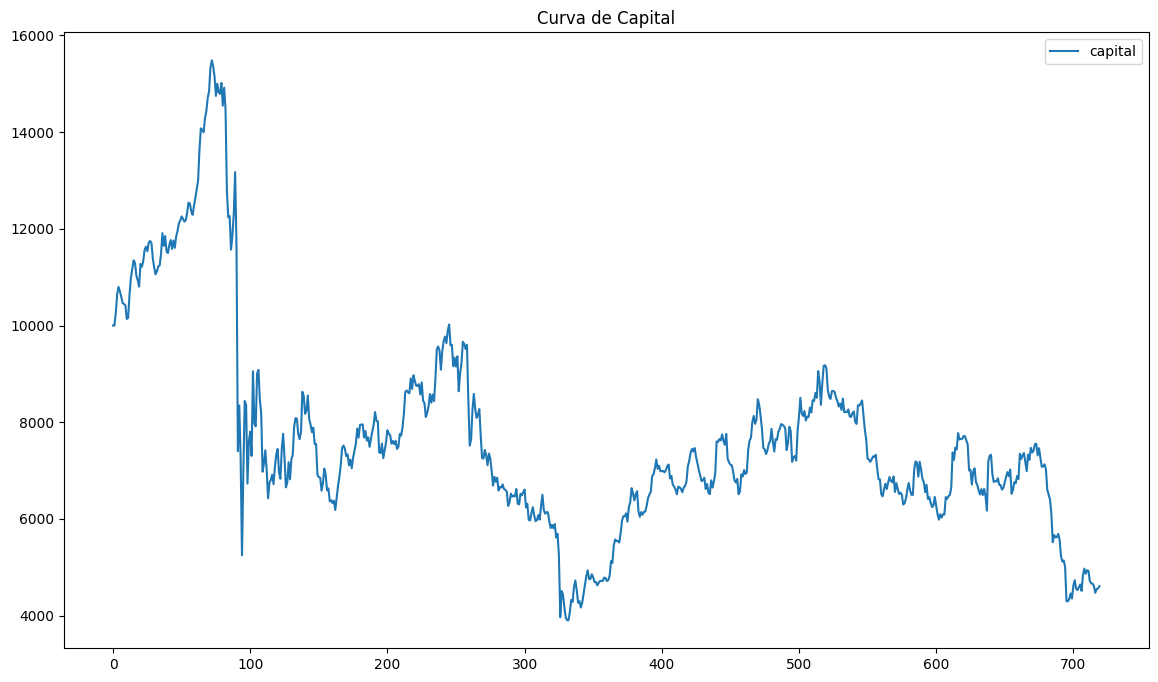

In [39]:
capital_df.plot(figsize=(14, 8), title='Curva de Capital')